# Лабораторная работа 3:Гауссово распределение, линейный дискриминантный анализ и наивный байес

### Брасалес Сарасбати 

### 1. Многомерное гауссово распределение

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_classification
from scipy.stats import norm

Генерируется два вектора одномерных нормальных распределений

In [2]:
M = 200 
sigma1 = 0.1 
sigma2 = 0.5  
x1 = np.random.randn(M, 1) * sigma1 
x2 = np.random.randn(M, 1) * sigma2
X = np.concatenate((x1, x2), axis=1) 

Мы создаем матрицу вращения и поворачиваем набор точек, вычисляем ковариационную матрицу и сравниваем график с графиком, полученным с использованием функции np.random.multivariate_normal().

In [3]:
alpha= np.pi/4
rotation_matrix=np.array([[np.cos(alpha),-np.sin(alpha)],
                         [np.sin(alpha),np.cos(alpha)]])
X_rotated=X @ rotation_matrix  

In [4]:
cov=np.cov(X_rotated.T)
cov

array([[0.10548296, 0.09910474],
       [0.09910474, 0.11282398]])

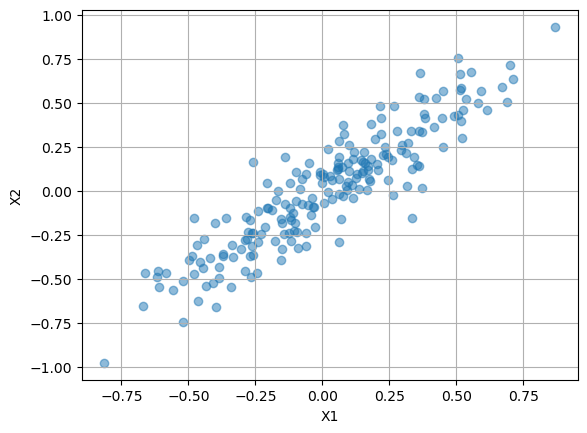

In [5]:
plt.scatter(X_rotated[:, 0], X_rotated[:, 1], alpha=0.5)
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid()
plt.show()

In [6]:
mean_rotated = np.mean(X_rotated, axis=0)
mean_rotated 

array([0.01627699, 0.0106774 ])

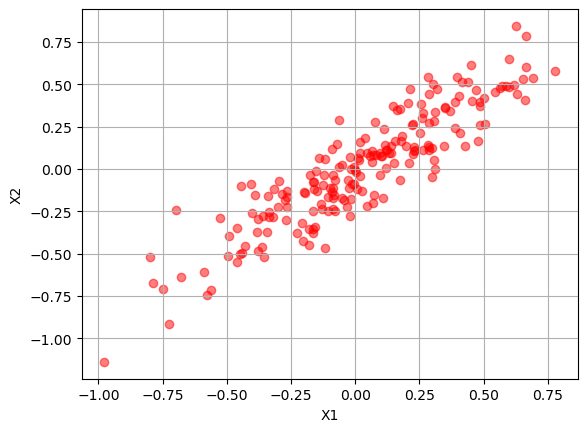

In [7]:
X_gaussian = np.random.multivariate_normal(mean_rotated, cov, M)
plt.scatter(X_gaussian[:, 0], X_gaussian[:, 1], alpha=0.5, color='r')
plt.xlabel('X1')
plt.ylabel('X2')
plt.grid()
plt.show()


### 2. Плотность вероятности гауссового распределения

Мы генерируем набор точек, вычисляем среднее значение и ковариационную матрицу. Для оценки функции плотности вероятности гауссовского распределения используется multivariate_normal, на графике отображаются набор точек и плотность вероятности.

In [8]:
X_random = np.random.rand(M, 2)
mean1 = np.mean(X_random, axis=0)
cov1 = np.cov(X_random, rowvar=False)

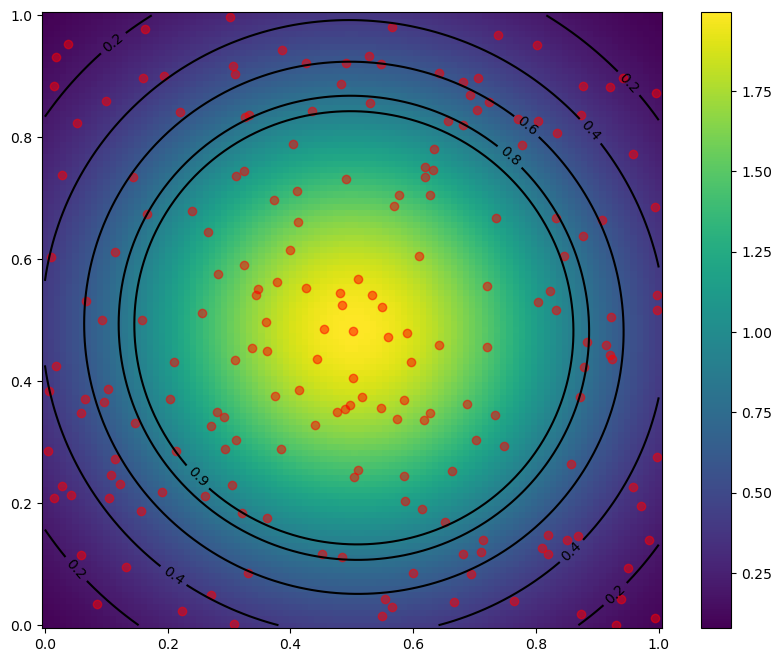

In [9]:
xx = np.linspace(0, 1, 100)  
yy = np.linspace(0, 1, 100)
XX, YY = np.meshgrid(xx, yy)  
pp = np.stack((XX.flatten(), YY.flatten()), axis=1)  

m = multivariate_normal(mean1, cov1)
ZZ = m.pdf(pp).reshape(XX.shape)  

plt.figure(figsize=(10, 8))
IMG = plt.pcolor(XX, YY, ZZ)  
plt.colorbar(IMG)

CS = plt.contour(XX, YY, ZZ, levels=[0.2, 0.4, 0.6, 0.8, 0.9], colors='k')
plt.clabel(CS, inline=1, fontsize=10)

plt.scatter(X_random[:, 0], X_random[:, 1], color='red', alpha=0.5, label='Puntos aleatorios')


### 3. Бинарная классификация

Мы создаем случайный набор данных для двух классов и двух признаков.

In [10]:
X, y = make_classification(n_samples=200, n_features=2, 
                           n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, flip_y=0.1, random_state=42)

Разделяем данные по классам

In [11]:
X0 = X[y == 0]
X1 = X[y == 1]

вычисляем средние значения 𝜇0, 𝜇1 и ковариационные матрицы для каждого класса. 

In [12]:
mu_0 = np.mean(X0, axis=0)
C_0 = np.cov(X0, rowvar=False)
mu_1 = np.mean(X1, axis=0)
C_1 = np.cov(X1, rowvar=False)

In [15]:
xx, yy = np.meshgrid(np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 200),
                     np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 200))

grid = np.c_[xx.ravel(), yy.ravel()]

Решение задачи классификации можно свести к оценке максимальной апостериорной вероятности (Maximum a posterior - MAP):
$$y = \underset{y\in{0,1}}{argmax} p(y|x) \tag{2}$$ 
для чего мы используем теорему Байеса:
$$p(y|x) = \frac{p(x|y)p(y)}{p(x)} \tag{3}$$
Вероятность p(y) — это доля точек набора данных, принадлежащих определенному классу. Вероятность p(x|y) называется правдоподобием, и в данном случае она моделируется с помощью гауссовской формулы.
$$p(x) = \frac{1}{(\sqrt{2\pi})^n \sqrt{detC}} e^{-\frac{1}{2}(x-\mu)^TС^{-1}(x-\mu)} \tag{1}$$  
где $x\in{R^n}$, $\mu\in{R^n}$ - среднее значение, $C$ - матрица ковариации.  


In [16]:
p_x_y0 = multivariate_normal.pdf(grid, mean=mu_0, cov=C_0)
p_x_y1 = multivariate_normal.pdf(grid, mean=mu_1, cov=C_1)

In [17]:
M = len(y)  
p_y0 = np.sum(y == 0) / M  
p_y1 = np.sum(y == 1) / M

Нам нужно классифицировать новую точку, для чего мы сравниваем вероятности p(y=0|x) и p(y=1|x): $$p(x|y=0)p(y=0) \overset{?}{<>} p(x|y=1)p(y=1) \tag{4}$$ Сравнение можно упростить, взяв логарифм (логарифм — возрастающая функция, и он не влияет на сравнения, кроме того, это помогает избежать ошибок с малыми числами).
Получаем:
$$y = \underset{y\in{0,1}}{argmax} log p(y|x) $$ 

Знак разности указывает, к какому классу принадлежит новая точка: если разность положительная, то точка принадлежит классу 0, если отрицательная — классу 1.

In [18]:
log_difference = np.log(p_x_y0 * p_y0) - np.log(p_x_y1 * p_y1)

Синие точки принадлежат классу 0, а оранжевые точки — классу 1. Линия принятия решения возникает, когда разность равна нулю.

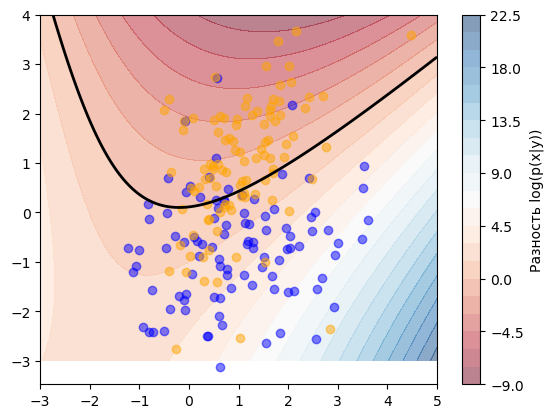

In [19]:
xx, yy = np.meshgrid(np.linspace(-3, 5, 200), np.linspace(-3, 4, 200))  
grid = np.dstack((xx, yy)).reshape(-1, 2)

plt.contourf(xx, yy, log_difference.reshape(xx.shape), levels=20, cmap='RdBu', alpha=0.5)
plt.colorbar(label='Разность log(p(x|y))')

plt.scatter(X0[:, 0], X0[:, 1], color='blue', alpha=0.5)
plt.scatter(X1[:, 0], X1[:, 1], color='orange', alpha=0.5)

plt.contour(xx, yy, log_difference.reshape(xx.shape), levels=[0], colors='black', linewidths=2)

### 4. LDA (linear discriminant analysis)

Для построения LDA мы предполагаем, что классы имеют гауссово распределение с одинаковой матрицей ковариации, но различными средними значениями 𝜇0≠𝜇1. LDA уменьшает размерность, чтобы классы были более разделимыми, и это достигается максимизацией расстояния между средними значениями классов и минимизацией дисперсии.

Чтобы классифицировать новую точку, нам нужно сравнить вероятности p(y=0|x) и p(y=1|x). Мы используем теорему Байеса.
Разница логарифмов может быть выражена как w^T x + b.

In [20]:
X, y = make_classification(n_samples=200, n_features=2, 
    n_informative=2, n_redundant=0,    
    n_classes=2, n_clusters_per_class=1, 
    class_sep=2.0, random_state=42
)

Для предсказания класса новой точки вычисляется линейная функция:
Если w^T x + b больше либо равно нулю, то точка принадлежит классу 1.
Если w^T x + b меньше нуля, то точка принадлежит классу 0.
LDA проецирует данные на прямую, определенную вектором w.
Граница принятия решения получается решением уравнения w^T x + b = 0.

In [21]:
from sklearn.base import BaseEstimator

class myLDA(BaseEstimator):
    def __init__(self):
        self.w = None  
        self.b = None 
        
    def fit(self, X, y):
        classes = np.unique(y)
        X0 = X[y == classes[0]]
        X1 = X[y == classes[1]]
        
        mu0 = np.mean(X0, axis=0)
        mu1 = np.mean(X1, axis=0)
        
        C0 = np.cov(X0, rowvar=False)
        C1 = np.cov(X1, rowvar=False)
        C = (C0 * len(X0) + C1 * len(X1)) / (len(X0) + len(X1))
        C_inv = np.linalg.inv(C)
        
        self.w = C_inv @ (mu1 - mu0)
        self.b = -0.5 * (mu1 @ C_inv @ mu1 - mu0 @ C_inv @ mu0)
        
    def predict(self, X):
        
        return (X @ self.w + self.b >= 0).astype(int)


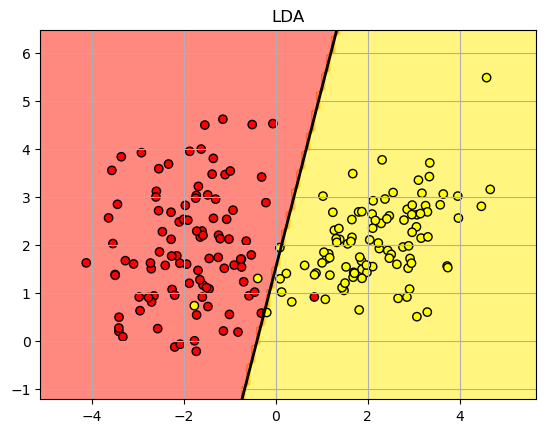

In [22]:
lda = myLDA()
lda.fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
Z = lda.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.autumn)  # Fondo en colores naranja y rojo
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.autumn)

x_vals = np.linspace(x_min, x_max, 100)
y_vals = -(lda.w[0] / lda.w[1]) * x_vals - (lda.b / lda.w[1])
plt.plot(x_vals, y_vals, color='black', linewidth=2)  # Línea de frontera en negro

plt.title('LDA')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid()
plt.show()


### 5. Наивный байесовый классификатор (NaiveBayes)

Классификатор Naïve Bayes предполагает, что признаки независимы друг от друга,
поэтому вероятность P(x|y) можно записать как произведение индивидуальных вероятностей для каждого признака.
$$p(x_1,x_2,...,x_n|y) => \prod\limits_{i=1}^{n}p(x_i|y)$$  
P(xi|y) вычисляется как нормальное распределение для одномерного случая.
$$p(xi|y) = \frac{1}{(\sqrt{2\pi})\sqrt{σi}^2} e^{-\frac{(xi-\mu)^2}{2}(\sigma i)^2}$$  

In [23]:
X, y = make_classification(n_samples=200, n_features=2, 
    n_informative=2, n_redundant=0, 
    n_classes=2, random_state=42
)

In [ ]:
Нормализуем, чтобы сумма вероятностей равнялась 1.
Чтобы предсказать класс новой выборки, выбирается класс с наибольшей апостериорной вероятностью.

In [24]:
class myNB(BaseEstimator):
    def __init__(self):
        self.class_stats = {}
        self.class_priors = {}

    def fit(self, X, y):
        classes = np.unique(y)
        
        for cls in classes:
            X_cls = X[y == cls]
            
            means = np.mean(X_cls, axis=0)
            variances = np.var(X_cls, axis=0)
            self.class_stats[cls] = {'mean': means, 'var': variances}
            self.class_priors[cls] = len(X_cls) / len(X)

    def predict_proba(self, X):
        posteriors = []
        for cls, stats in self.class_stats.items():
    
            mean = stats['mean']
            var = stats['var']
            likelihood = norm.pdf(X, loc=mean, scale=np.sqrt(var))
            total_likelihood = np.prod(likelihood, axis=1)
            posterior = total_likelihood * self.class_priors[cls]
            posteriors.append(posterior)
        
        posteriors = np.array(posteriors)
        return posteriors / posteriors.sum(axis=0)

    def predict(self, X):
        posteriors = self.predict_proba(X)
        return np.argmax(posteriors, axis=0)

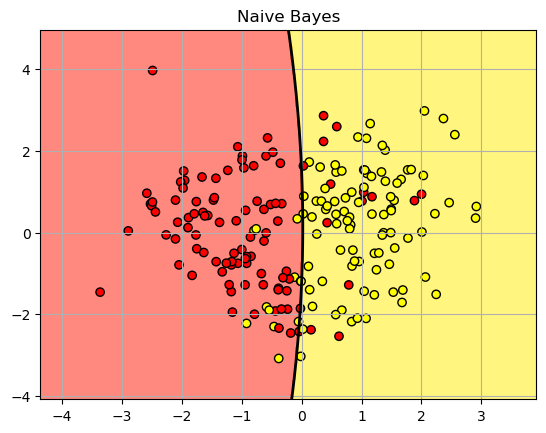

In [25]:
nb = myNB()
nb.fit(X, y)

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300)) 
Z = nb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.autumn) 
probs = nb.predict_proba(np.c_[xx.ravel(), yy.ravel()]) 
probs = probs[1, :].reshape(xx.shape)
plt.contour(xx, yy, probs, levels=[0.5], colors='black', linewidths=2) 
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.autumn)

plt.title('Naive Bayes')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.grid()
plt.show()

### 6. Сравнение двух алгоритмов: LDA и NB

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [31]:
X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, 
                           n_clusters_per_class=1, random_state=42)


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lda = myLDA()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)

nb = myNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

accuracy_lda = accuracy_score(y_test, y_pred_lda)
precision_lda = precision_score(y_test, y_pred_lda)
recall_lda = recall_score(y_test, y_pred_lda)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)

In [33]:
print(f"Метрики LDA:")
print(f"Точность (Accuracy): {accuracy_lda:.2f}")
print(f"Прецизионность (Precision): {precision_lda:.2f}")
print(f"Полнота (Recall): {recall_lda:.2f}\n")

print(f"Метрики Наивного Байеса:")
print(f"Точность (Accuracy): {accuracy_nb:.2f}")
print(f"Прецизионность (Precision): {precision_nb:.2f}")
print(f"Полнота (Recall): {recall_nb:.2f}")

Метрики LDA:
Точность (Accuracy): 0.90
Прецизионность (Precision): 0.93
Полнота (Recall): 0.85

Метрики Наивного Байеса:
Точность (Accuracy): 0.91
Прецизионность (Precision): 0.93
Полнота (Recall): 0.86


### Вывод

 Оба модели показывают очень схожие результаты по общей точности предсказаний, с небольшим преимуществом в пользу Наивного Байеса. Они одинаково хорошо справляются с предотвращением ложных положительных срабатываний, что означает, что при предсказании положительного класса результат оказывается правильным в 93% случаев. Оба модели также демонстрируют схожие показатели полноты, но Наивный Байес немного лучше распознает истинные положительные примеры, чем LDA. Это говорит о том, что Наивный Байес немного лучше идентифицирует все элементы, принадлежащие к положительному классу.